In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [3]:
def choose_agents(N, method=None):

    # could define a PDF from which i and j are drawn

    if method == 'NN':
        speaker = np.random.randint(N)
        listener = np.random.choice([speaker-2, speaker-1, speaker+1, speaker+2], p=[0.1, 0.4, 0.4, 0.1])
        listener = listener%N

    else:
        speaker, listener = np.random.choice(N, size=2, replace=False)
        
    return speaker, listener
    
def choose_meaning(i, M, method=None):

    # could define a PDF dependent on the speaker i and the meaning intended m
    # intend = np.random.choice(M, p=rho(i,m))

    if method == 'uniform':
        intend = np.random.choice(M)
    else: 
        intend = np.random.choice(M)
    return intend

def choose_signal(i, intend, S, prob_array, method=None):

    if method == 'noise':
        # add noise
        pass 

    signal = np.random.choice(S, p=prob_array)

    return signal

def infer_meaning(j, M, prob_array):

    return np.random.choice(M, p=prob_array)

def get_feedback(mu_pos, mu_neg, speaker, listener, intend, infer):

    # generally, chosen from distribution lambda_ij (m*, m')
    # could allow for near misses (depending on the meaning space)

    # positive feedback, with mu_pos > mu_neg

    feedback = mu_pos if infer == intend else mu_neg
    return feedback

def U(phi, method=None):

    if method == 'linear':
        return phi
    else:
        return phi * (1 - phi)

def intelligibility(phi, N, S, M):

    psi = phi / phi.sum(axis=2)[:, :, np.newaxis]
    A = 0
    for n in range(1, N):
        A += 1/(N * (N-1) * M) * (phi * np.roll(psi, n, axis=0)).sum()
    
    return A


In [4]:
def run_model(mu_pos, mu_neg, N=2, S=3, M=3, n_steps=1e6):

    phi = np.ones((N,S,M)) * 1/S

    fig, axs = plt.subplots(1, N, figsize=(8, int(8/N)))

    for i in range(int(n_steps)):

        speaker, listener = choose_agents(N)
        intend = choose_meaning(speaker, M)
        signal = choose_signal(speaker, intend, S, prob_array=phi[speaker,:,intend])
        infer = infer_meaning(listener, M, phi[listener,signal,:] / np.sum(phi[listener,signal,:]))
        feedback = get_feedback(mu_pos, mu_neg, speaker, listener, intend, infer)

        phi[speaker,signal,intend] += (feedback * U(phi[speaker,signal,intend]))
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])

    for i, ax in enumerate(axs.flatten()):
        ax.matshow(phi[i], cmap='magma', vmin=0, vmax=1)
        ax.set_xlabel('meaning space')
        ax.set_ylabel('signal space')
        
    plt.show()

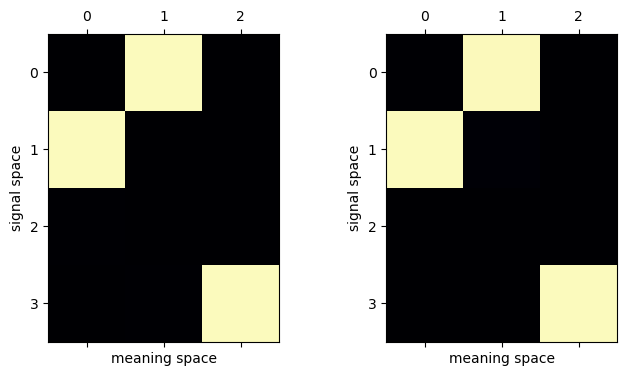

In [10]:
run_model(0.02, 0.01, N=2, S=4, M=3, n_steps=100000)

In [27]:
%matplotlib notebook

MovieWriter ffmpeg unavailable; using Pillow instead.


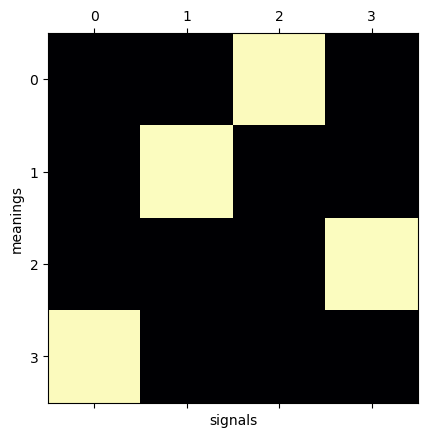

In [44]:
def initiate_phi(N, S, M): return np.ones((N,S,M)) * 1/S

def func(frame, img, phi, N, S, M, conversations, mu_pos, mu_neg):

    for i in range(int(conversations)):

        speaker, listener = choose_agents(N)
        intend = choose_meaning(speaker, M)
        signal = choose_signal(speaker, intend, S, prob_array=phi[speaker,:,intend])
        infer = infer_meaning(listener, M, phi[listener,signal,:] / np.sum(phi[listener,signal,:]))
        feedback = get_feedback(mu_pos, mu_neg, speaker, listener, intend, infer)

        phi[speaker,signal,intend] += (feedback * U(phi[speaker,signal,intend]))
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])
    
    img.set_data(phi[0])
    return img,

def good_animation_values():

    N, S, M = 2, 3, 3
    # conversations, mu_pos, mu_neg = 1000, 2e-2, 1e-2
    conversations, mu_pos, mu_neg = 1000, 1e-2, -1e-2

    N, S, M = 2, 4, 4
    # conversations, mu_pos, mu_neg = 1000, 2e-2, 1e-2
    conversations, mu_pos, mu_neg = 2000, 1e-2, -1e-2

    return N, S, M, conversations, mu_pos, mu_neg

N, S, M, conversations, mu_pos, mu_neg = good_animation_values()

fig, ax = plt.subplots()
phi = initiate_phi(N, S, M)
img = ax.matshow(phi[0], cmap='magma', vmin=0, vmax=1)
ax.set_xlabel('signals')
ax.set_ylabel('meanings')
anim = animation.FuncAnimation(fig, func, fargs=(img, phi, N, S, M, conversations, mu_pos, mu_neg, ), frames=50, interval=100)
# writervideo = animation.FFMpegWriter(fps=60)
anim.save('animation.gif')

HTML(anim.to_jshtml())



# animate_language(2, 3, 3)


## Limits of $\mu_{±}$

Could try and test the limits of the $\mu_-$ and $\mu_+$ values, possibly by fixing $\mu_+$ and varying $\mu_-$ until the system cannot reach equilibrium.

We expect to see instability in the case where $\mu_- < - \frac{\mu_+}{M-1}$.

In context, this relates to the eigenstates where all speakers differentiate among the meanings as well as the signals (uniform along N but summing to zero along S and M).

The eigenvalue is 
$$\frac{1}{NM} \left( \frac{U'(1/S)}{S} \left[ \mu_- + \frac{\mu_+ - \mu_-}{M} \right] + U(1/S) \frac{\mu_+ - \mu_-}{M} \right)$$

We expect a faster convergence when $\mu_+$ is much greater than $\mu_-$. The case where we can expect instability is when $\mu_-$ is very negative. 

If $\mu_- < 0$ then with increasing $M$ the meanings become increasingly hard to differentiate.

Structured meaning spaces allowing reinforcement for near misses in communication may facilitate easier communication.

In the case S,M = 3,3 we have the threshold $\mu_- < -\mu_+ / 2$ for the first term to become negative.

The eigenvalue is $\frac{1}{NM} \left( \frac{1 - 2/S}{S} \left[ \mu_- + \frac{\mu_+ - \mu_-}{M} \right] + (1/S)(1-1/S) \ \frac{\mu_+ - \mu_-}{M} \right) = \frac{1}{6} (1/9) [ \mu_- + \frac{\mu_+ - \mu_-}{3} ]$

In [5]:
def U_derivative(phi): return 1 - 2*phi

def eigenvalue(N, S, M, mu_pos, mu_neg):
    return 1/(N*M) * ( U_derivative(1/S) / S * (mu_neg + (mu_pos - mu_neg) / M) + U(1/S) * (mu_pos - mu_neg) / M )

def time_to_equilibrium(mu_pos, mu_neg, N=2, S=3, M=3, max_steps=1e7, threshold=.95):

    phi = np.ones((N,S,M)) * 1/S

    for timestep in range(int(max_steps)):

        speaker, listener = choose_agents(N)
        intend = choose_meaning(speaker, M)
        signal = choose_signal(speaker, intend, S, prob_array=phi[speaker,:,intend])
        infer = infer_meaning(listener, M, phi[listener,signal,:] / np.sum(phi[listener,signal,:]))
        feedback = get_feedback(mu_pos, mu_neg, speaker, listener, intend, infer)

        phi[speaker,signal,intend] += (feedback * U(phi[speaker,signal,intend]))
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])

        if intelligibility(phi, N, S, M) >= threshold * (M/S): break
            
    return timestep

In [41]:
print(eigenvalue(2, 4, 4, 0.01, -5/6*0.01))

4.8828125e-05


In [6]:
def test_feedback_values():

    N, S, M = 2, 4, 4
    mu_pos = 0.01
    mu_negs = np.linspace(-2*mu_pos, 0.005, 15) #[-0.01, -0.1, 0.005, 0.01]
    max_steps = 1e6

    eq_times = []

    for mu_neg in mu_negs:
        eq_time = time_to_equilibrium(mu_pos, mu_neg, N, S, M, max_steps=max_steps)
        print('mu- = {: .3f} --- time to equilibrium = {}'.format(mu_neg, eq_time))
        eq_times.append(eq_time) #if eq_time != max_steps - 1:
    
    return mu_negs, eq_times
        
mu_negs, eq_times = test_feedback_values()

KeyboardInterrupt: 

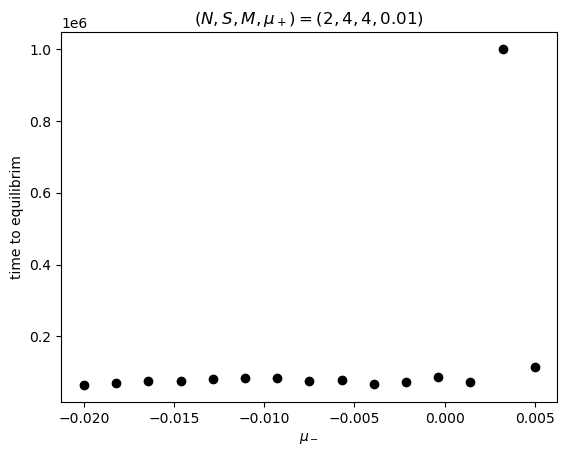

In [38]:
fig, ax = plt.subplots()
ax.plot(mu_negs, eq_times, 'ko')
ax.set_xlabel('$\mu_-$')
ax.set_ylabel('time to equilibrim')
ax.set_title(f'$(N,S,M,\mu_+) = ({2},{4},{4},{0.01})$')

plt.show()

In [36]:
for M_ in range(4, 20):
    alpha_thresh = (3 - 2*M_) / (M_**2 - 4*M_ + 3)
    print(f'M = {M_}: mu- / mu+ < {alpha_thresh:.2f}')

M = 4: mu- / mu+ < -1.67
M = 5: mu- / mu+ < -0.88
M = 6: mu- / mu+ < -0.60
M = 7: mu- / mu+ < -0.46
M = 8: mu- / mu+ < -0.37
M = 9: mu- / mu+ < -0.31
M = 10: mu- / mu+ < -0.27
M = 11: mu- / mu+ < -0.24
M = 12: mu- / mu+ < -0.21
M = 13: mu- / mu+ < -0.19
M = 14: mu- / mu+ < -0.17
M = 15: mu- / mu+ < -0.16
M = 16: mu- / mu+ < -0.15
M = 17: mu- / mu+ < -0.14
M = 18: mu- / mu+ < -0.13
M = 19: mu- / mu+ < -0.12


In [12]:
def simple_model_eigenvalue(mu, N, S, M): return mu / (N*S*M) * (2/M * (1-1/S) - (1-2/M) * (1-2/S))

S_arr, M_arr = np.arange(3, 10), np.arange(3, 10)
sign_array = np.zeros((len(S_arr), len(M_arr)))
for S_ in S_arr:
    for M_ in M_arr:
        # sign = '+' if simple_model_eigenvalue(mu=0.01, N=2, S=S_, M=M_) > 0 else '-'
        # print(f'S = {S_} -- M = {M_} ||| {sign}')
        sign_array[S_-3, M_-3] = simple_model_eigenvalue(mu=0.01, N=2, S=S_, M=M_)

print(sign_array>0)

[[ True  True  True False False False False]
 [ True  True  True False False False False]
 [ True  True False False False False False]
 [ True  True False False False False False]
 [ True  True False False False False False]
 [ True  True False False False False False]
 [ True  True False False False False False]]
